<a href="https://colab.research.google.com/github/na-go/Prac_PyTorch/blob/master/Prac_PyTorch_Sec3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section3
## TOC
1. データ読み込み
2. ネットワーク定義
3. 損失関数
4. 最適化関数
5. 学習
6. 推論

In [1]:
# Google Driveにマウント
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd gdrive/My Drive/Colab Notebooks/prac_Putorch

/content/gdrive/My Drive/Colab Notebooks/prac_Putorch


In [0]:
# モジュールのインポート
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# データの読み込み
train_dataset = torchvision.datasets.CIFAR10(root = "./data/",
                                             train = True,
                                             transform = transforms.ToTensor(),
                                             download = True
                                             )

test_dataset = torchvision.datasets.CIFAR10(root = "./data",
                                            train = False,
                                            transform = transforms.ToTensor(),
                                            download = True
                                            )
image, label = train_dataset[0]
print(image.size())
print(label)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32])
6


In [0]:
## Dataloaderの定義
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 64,
                                           shuffle = True,
                                           num_workers = 2
                                           )
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size = 64,
                                          shuffle = False,
                                          num_workers = 2
                                          )

In [6]:
## Tensor形状の確認
for images, labels in train_loader:
  print(images.size())
  print(images[0].size())
  print(labels.size())
  break
  """
    torch.Size([64,3,32,32]) バッチサイズ, チャンネル数, 縦, 横
    torch.Size([3,32,32]) チャンネル数, 縦, 横
    torch.Size([64]) バッチサイズ
  """

torch.Size([64, 3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([64])


In [0]:
# ネットワーク定義
## MLPネットワークの定義

num_input = 32 * 32 * 3 #入力の次元 縦*横*チャンネル数
num_classes = 10 # 出力の次元 CIFAR10は10種類のラベルがある
class MLPNet(nn.Module):
  def __init__(self):
    super(MLPNet, self).__init__()
    self.fc1 = nn.Linear(num_input, 600)
    self.fc2 = nn.Linear(600, 600)
    self.fc3 = nn.Linear(600, num_classes)
    self.dropout1 = nn.Dropout2d(0.2)
    self.dropout2 = nn.Dropout2d(0.2)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)
    return F.relu(self.fc3(x))

device = "cuda" if torch.cuda.is_available() else "cpu"
mlpnet = MLPNet().to(device)

In [0]:
# 損失関数と最適化関数の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlpnet.parameters(),lr = 0.01, momentum = 0.9, weight_decay=5e-4)

In [9]:
# 学習
num_epochs = 50 # エポック数の定義, 今回は50

## 損失と正解率を保存するリスト
train_loss_list = []
train_acc_list = []
eval_loss_list = []
eval_acc_list = []

for epoch in range(num_epochs):
  # 損失と正解率の初期化
  train_loss = 0
  train_acc = 0
  eval_loss = 0
  eval_acc = 0

  ##Trainingモード=====================
  mlpnet.train() # 訓練モードに切り替える
  # ミニバッチごとに分割して読み込む
  for i, (images, labels) in enumerate(train_loader):
    # view関数で縦横32次元, チャンネル3次元の画像データを1次元に変換
    images, labels = images.view(-1,32*32*3).to(device), labels.to(device)

    optimizer.zero_grad() # 勾配をリセット
    outputs = mlpnet(images) # 順伝播を計算
    loss = criterion(outputs, labels) # 損失の計算 このときoutputsとlabelsの次元は等しい

    train_loss += loss.item() # 損失のミニバッチ分を溜め込む
    train_acc += (outputs.max(1)[1] == labels).sum().item() # 正解率のミニバッチ分を溜め込む
    loss.backward() # 逆伝播の計算
    optimizer.step() # 重みの更新

  # 平均損失と平均正解率を計算
  avg_train_loss = train_loss / len(train_loader.dataset)
  avg_train_acc = train_acc / len(train_loader.dataset)

  ##Evaluationモード====================
  mlpnet.eval() # 評価モードへの切り替え
  # 評価する時に必要のない計算が走らないようにtorch.no_gradを用いる.
  with torch.no_grad():
    for images, labels, in test_loader:
      images, labels = images.view(-1, 32*32*3).to(device), labels.to(device)
      outputs = mlpnet(images)
      loss = criterion(outputs, labels)
      eval_loss += loss.item()
      eval_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_eval_loss = eval_loss / len(test_loader.dataset)
    avg_eval_acc = eval_acc / len(test_loader.dataset)

    # 経過ログ
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'.format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_eval_loss, val_acc=avg_eval_acc))

    
    # 最後に可視化するための損失と正解率のデータ保存
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    eval_loss_list.append(avg_eval_loss)
    eval_acc_list.append(avg_eval_acc)


Epoch [1/50], Loss: 0.0302, val_loss: 0.0274, val_acc: 0.3714
Epoch [2/50], Loss: 0.0274, val_loss: 0.0267, val_acc: 0.3936
Epoch [3/50], Loss: 0.0264, val_loss: 0.0253, val_acc: 0.4266
Epoch [4/50], Loss: 0.0258, val_loss: 0.0247, val_acc: 0.4367
Epoch [5/50], Loss: 0.0252, val_loss: 0.0248, val_acc: 0.4346
Epoch [6/50], Loss: 0.0246, val_loss: 0.0239, val_acc: 0.4519
Epoch [7/50], Loss: 0.0243, val_loss: 0.0237, val_acc: 0.4585
Epoch [8/50], Loss: 0.0240, val_loss: 0.0235, val_acc: 0.4646
Epoch [9/50], Loss: 0.0237, val_loss: 0.0241, val_acc: 0.4493
Epoch [10/50], Loss: 0.0234, val_loss: 0.0229, val_acc: 0.4789
Epoch [11/50], Loss: 0.0231, val_loss: 0.0225, val_acc: 0.4835
Epoch [12/50], Loss: 0.0229, val_loss: 0.0230, val_acc: 0.4731
Epoch [13/50], Loss: 0.0226, val_loss: 0.0224, val_acc: 0.4907
Epoch [14/50], Loss: 0.0225, val_loss: 0.0225, val_acc: 0.4777
Epoch [15/50], Loss: 0.0222, val_loss: 0.0221, val_acc: 0.5001
Epoch [16/50], Loss: 0.0220, val_loss: 0.0219, val_acc: 0.4975
E

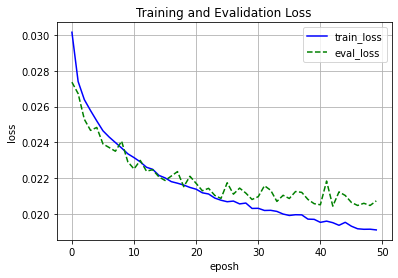

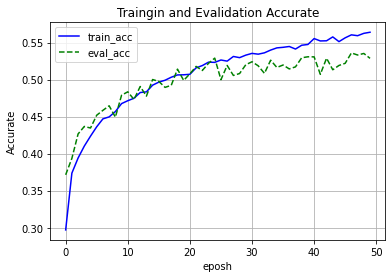

In [10]:
## 結果の可視化
### 損失
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color="blue", linestyle="-", label="train_loss")
plt.plot(range(num_epochs), eval_loss_list, color="green", linestyle="--", label = "eval_loss")
plt.legend()
plt.xlabel("eposh")
plt.ylabel("loss")
plt.title("Training and Evalidation Loss")
plt.grid()

### 正解率
plt.figure()
plt.plot(range(num_epochs), train_acc_list, color="blue", linestyle="-", label="train_acc")
plt.plot(range(num_epochs), eval_acc_list, color="green", linestyle="--", label = "eval_acc")
plt.legend()
plt.xlabel("eposh")
plt.ylabel("Accurate")
plt.title("Traingin and Evalidation Accurate")
plt.grid()

In [11]:
# 推論
## ネットワークの保存
torch.save(mlpnet.state_dict(), "mlpnetCIFAR10.ckpt")

## ネットワークの読み込み
mlpnet2 = MLPNet().to(device)
mlpnet2.load_state_dict(torch.load("mlpnetCIFAR10.ckpt"))

<All keys matched successfully>

In [12]:
mlpnet2.eval()
with torch.no_grad():
  total = 0
  test_acc = 0
  for images, labels in test_loader:
    images, labels = images.view(-1,32*32*3).to(device), labels.to(device)
    outputs = mlpnet2(images)
    test_acc += (outputs.max(1)[1] == labels).sum().item()
    total += labels.size(0)
  print("正解率 : {} %".format(100* test_acc/total))
  

正解率 : 52.87 %
